
=== Fetching Beam Energies from MDSplus ===
Shot 112394: 3.68 kJ
Shot 112396: 3.57 kJ
Shot 112398: 3.79 kJ
Shot 112401: 4.06 kJ
Shot 112402: 4.00 kJ
Shot 112403: 4.13 kJ
Shot 112404: 4.02 kJ
Shot 112405: 4.14 kJ
Shot 112406: 4.16 kJ
Shot 112407: 0.96 kJ
Shot 112402: 4.00 kJ
Shot 112403: 4.13 kJ
Shot 112404: 4.02 kJ
Shot 112405: 4.14 kJ
Shot 112406: 4.16 kJ
Shot 112407: 0.96 kJ
Shot 112410: 2.98 kJ
Shot 112411: 3.83 kJ
Shot 112413: 4.02 kJ
Shot 112416: 3.92 kJ
Shot 112417: 3.97 kJ
Shot 112410: 2.98 kJ
Shot 112411: 3.83 kJ
Shot 112413: 4.02 kJ
Shot 112416: 3.92 kJ
Shot 112417: 3.97 kJ
Shot 112418: 3.93 kJ
Shot 112419: 4.01 kJ
Shot 112420: 4.18 kJ
Shot 112422: 3.82 kJ
Shot 112423: 3.89 kJ
Shot 112418: 3.93 kJ
Shot 112419: 4.01 kJ
Shot 112420: 4.18 kJ
Shot 112422: 3.82 kJ
Shot 112423: 3.89 kJ
Shot 112424: 3.89 kJ
Shot 112425: 3.83 kJ
Shot 112427: 3.90 kJ
Shot 112428: 3.80 kJ
Shot 112433: 3.94 kJ
Shot 112424: 3.89 kJ
Shot 112425: 3.83 kJ
Shot 112427: 3.90 kJ
Shot 112428: 3.80 kJ
Shot 11243

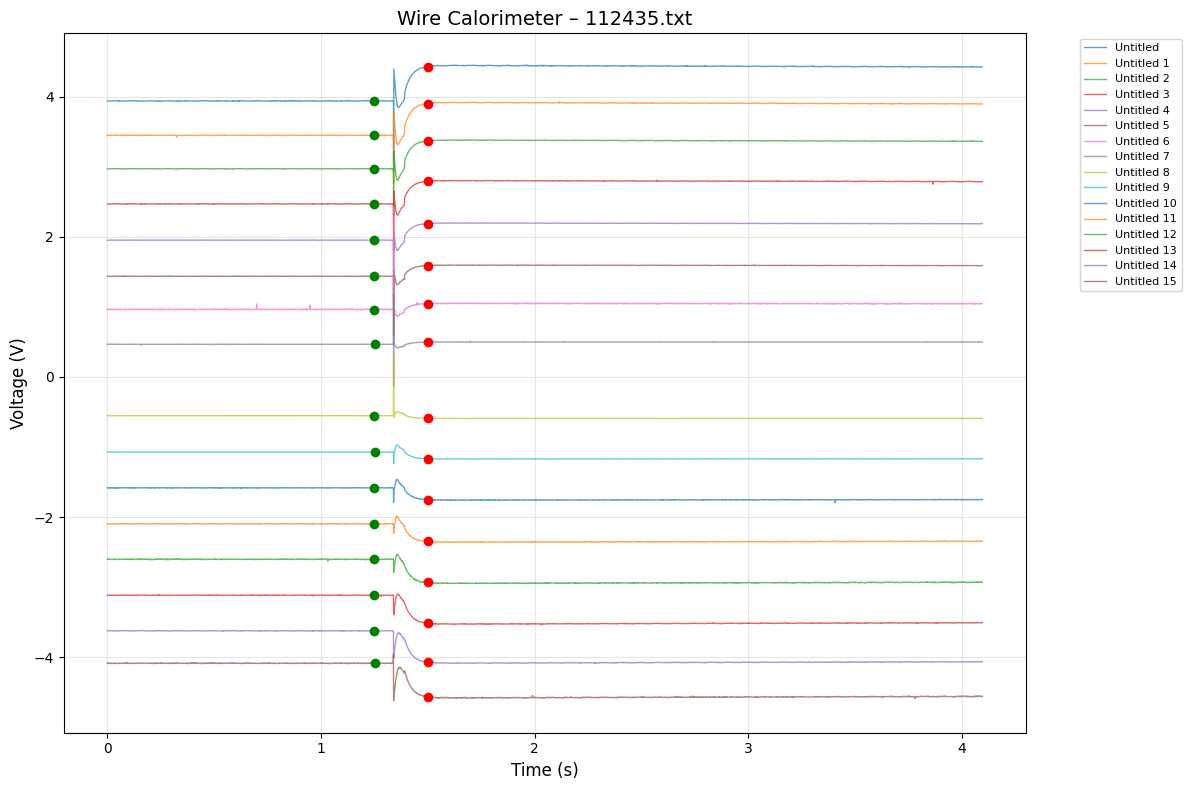

In [28]:
# NBI Wire Calorimeter Analysis
# H. Gajani

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main')
from bills_LTX_MDSplus_toolbox import get_tree_conn, get_data
import MDSplus as mds

# Wire properties
WIRE_CURRENT = 0.7  # Amps
TCR = 0.0045  # Tungsten temp coefficient

def get_avg_beam_power(shot, v_thresh=5000.0):
    """Fetch total beam energy from MDSplus during beam-on period."""
    try:
        if shot > 200000:
            treename = 'ltx_nbi'
            prefix = ''
        else:
            treename = 'ltx_b'
            prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot, treename=treename)
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        
        ib = np.interp(tv, ti, ib)
        pb = ib * vb / 1000.0  # kW
        
        mask = vb > v_thresh
        if np.any(mask):
            # Integrate power over time to get total energy
            tv_beam = tv[mask]
            pb_beam = pb[mask]
            total_energy = np.trapz(pb_beam, tv_beam)  # kJ (kW * s)
            return total_energy
        else:
            return np.nan
            
    except (mds.mdsExceptions.TreeNODATA, Exception) as e:
        print(f'Warning: Could not fetch beam power for shot {shot}: {e}')
        return np.nan

# Shot list
shot_list = [112394, 112396,112398, 112401, 112402, 
112403, 112404, 112405, 112406, 112407, 112410, 112411, 
112413, 112416, 112417, 112418, 112419, 112420, 112422, 
112423, 112424, 112425, 112427, 112428, 112433, 112435]
#shot_list = [112406]


base_path = Path("/p/ltxdata/users/Hussain/WCAL/10-20")
file_list = [base_path / f"{shot}.txt" for shot in shot_list]

def find_data_start(path: Path) -> int:
    """Find where actual data starts in LVM file."""
    with open(path, "r", errors="ignore") as f:
        end = -1
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end = i
    return end + 1

def load_lvm(path: Path):
    """Load LVM file into dataframe."""
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row, engine="python")
    df = df.dropna(axis=1, how="all").reset_index(drop=True)
    df["Time (s)"] = df.index * 1e-3  # 1 kHz sampling
    for c in df.columns:
        if c not in ["Time (s)", "Comment"]:
            df[c] = pd.to_numeric(df[c])
    return df

# Pulse/plateau detection params
TIME_WINDOW = (1.25, 1.5)
EPS_DERIV = 0.01
MIN_DUR = 0.015
DERIV_FLOOR = 0.05

def rolling_slope(t, y, win=5):
    """Calculate rolling derivative."""
    t = np.asarray(t, float); y = np.asarray(y, float)
    if len(t) <= win:
        return np.full_like(t, np.nan)
    dt = t[win:] - t[:-win]
    m = (y[win:] - y[:-win]) / np.where(dt == 0, np.nan, dt)
    return np.r_[m, np.full(win, np.nan)]

def pick_pulse_plateau_gate(t_ser, y_ser, win=5):
    """Find pulse and plateau indices for gating."""
    t = np.asarray(t_ser, float)
    y = np.asarray(y_ser, float)

    # restrict to time window
    mask = (t >= TIME_WINDOW[0]) & (t <= TIME_WINDOW[1])
    if not np.any(mask):
        return 0, 0
    idx0, idx1 = np.where(mask)[0][[0, -1]]

    m = rolling_slope(t, y, win=win)

    #finding pulse_idx (intital pulse point)
    #pick the first strong negative slope as the pulse and then search 
    #for a positive slope and flattening for the plateau regardless of the order of slopes in the raw data
    pulse_idx = None
    for i in range(idx0, idx1):
        if m[i] < -DERIV_FLOOR:
            # look backwards to last near-zero slope
            back = np.where(np.abs(m[idx0:i]) < EPS_DERIV)[0]
            if len(back):
                pulse_idx = back[-1]
            else:
                pulse_idx = i
            break

    if pulse_idx is None:
        # fallback = strongest negative slope inside the window
        rel_idx = np.nanargmin(m[idx0:idx1+1])
        pulse_idx = idx0 + int(rel_idx)

    #making sure pulse idx is in the window we want
    pulse_idx = max(idx0, min(pulse_idx, idx1))

    #finding plateau_idx (point where slope flattens after pulse)
    plateau_idx = idx1
    found = False
    for i in range(pulse_idx+1, idx1-win):
        # slope > 0 and flattens for MIN_DUR
        if m[i] > 0:
            dur = int(MIN_DUR / (t[1]-t[0]))
            if i+dur < len(m) and np.all(np.abs(m[i:i+dur]) < EPS_DERIV):
                plateau_idx = min(i+5, len(t)-1)
                found = True
                break
    if not found:
        plateau_idx = idx1

    return int(pulse_idx), int(plateau_idx)

#load all datasets
datasets = {f.name: load_lvm(f) for f in file_list}
time_col = "Time (s)"

#building a table to manually confirm data
def build_power_table(df, shot_name, beam_energy_kj):
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
    rows = []

    for idx, col in enumerate(channel_cols):
        y = df[col].values
        pulse_idx, plateau_idx = pick_pulse_plateau_gate(df[time_col], y)

        resistance = y / WIRE_CURRENT  # Ohm's law
        
        # 2 seconds of data points (2s * 1000 samples/s = 2000 points)
        two_sec_points = 2000
        
        # V_1: 2 seconds of data at t=0 (indices 0 to 2000)
        v1_start = 0
        v1_end = two_sec_points
        V_1 = np.mean(y[v1_start:v1_end])
        R_1 = V_1 / WIRE_CURRENT
        
        # V_2: 2 seconds of data at t=1.8s (index 1800 to 3800, since 1.8s * 1000 = 1800)
        v2_start = 1800
        v2_end = v2_start + two_sec_points
        V_2 = np.mean(y[v2_start:v2_end])
        R_2 = V_2 / WIRE_CURRENT

        # ΔR and ΔT
        delta_R = R_2 - R_1
        delta_T = delta_R / (R_1 * TCR) if R_1 != 0 else np.nan
        delta_V = V_2 - V_1
        # Normalize by beam energy
        delta_T_normalized = delta_T / beam_energy_kj if (not np.isnan(delta_T) and beam_energy_kj > 0) else np.nan
        
        rows.append({
            "Shot": shot_name,
            "Channel": f"Channel {idx}",
            "(PULSE IDX)": pulse_idx,
            "(PLATEAU_IDX)": plateau_idx,
            "Voltage 1 (V)": V_1,  # 2s average at t=0
            "Voltage 2 (V)": V_2,  # 2s average at t=1.8s
            "Delta_V (V)": delta_V, 
            "ΔT (°C)": delta_T,
            "Beam Energy (kJ)": beam_energy_kj,
            "ΔT/E (°C/kJ)": delta_T_normalized
        })

    return pd.DataFrame(rows)

# Process all shots and collect results
all_results = []
beam_energies = {}

print("\n=== Fetching Beam Energies from MDSplus ===")
for shot_file, df in datasets.items():
    shot_number = int(Path(shot_file).stem)
    beam_energy = get_avg_beam_power(shot_number)
    beam_energies[shot_file] = beam_energy
    print(f"Shot {shot_number}: {beam_energy:.2f} kJ" if not np.isnan(beam_energy) else f"Shot {shot_number}: No data")

print("\n=== Processing Wire Calorimeter Data ===")

# Open file to write all tables
all_tables_file = Path.home() / "all_shot_tables.txt"
with open(all_tables_file, 'w') as f:
    f.write("NBI Wire Calorimeter Analysis - All Shot Tables\n")
    f.write("=" * 100 + "\n\n")
    
    for shot_file, df in datasets.items():
        beam_energy = beam_energies[shot_file]
        table = build_power_table(df, shot_file, beam_energy)
        all_results.append(table)
        
        # Print to console
        print(f"\n\n{'='*80}")
        print(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ")
        print('='*80)
        print(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                     'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        
        # Write to file
        f.write("\n\n" + "="*100 + "\n")
        f.write(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ\n")
        f.write("="*100 + "\n")
        f.write(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                       'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        f.write("\n")

print(f"\n\nProcessed {len(all_results)} shots total")
print(f"All shot tables saved to: {all_tables_file}")

# Combine all results
combined_table = pd.concat(all_results, ignore_index=True)

# ===== PER-SHOT RANKING =====
# Calculate aggregate statistics for each shot across all channels
shot_summary = combined_table.groupby('Shot').agg({
    'ΔT (°C)': ['mean', 'max', 'std'],  # mean, max, and std of ΔT across channels
    'ΔT/E (°C/kJ)': ['mean', 'max', 'std'],  # mean, max, and std of normalized ΔT/E
    'Beam Energy (kJ)': 'first',  # beam energy (same for all channels in a shot)
    'Channel': 'count'  # number of channels
}).reset_index()

# Flatten multi-level column names
shot_summary.columns = ['Shot', 'ΔT_mean', 'ΔT_max', 'ΔT_std', 
                        'ΔT/E_mean', 'ΔT/E_max', 'ΔT/E_std',
                        'Beam Energy (kJ)', 'Num_Channels']

# Save shot summary to CSV file in home directory
output_file = Path.home() / "shot_summary.txt"
shot_summary.to_csv(output_file, index=False)
print(f"\nShot summary saved to: {output_file}")


# Rank shots by mean ΔT (highest to lowest) On average, the wire calorimeter heated up by xyz°C across all positions
print("\n\n SHOT RANKING by Mean ΔT (Highest to Lowest)")
shot_rank_mean = shot_summary.sort_values('ΔT_mean', ascending=False).reset_index(drop=True)
shot_rank_mean['Rank'] = shot_rank_mean.index + 1
print(shot_rank_mean[['Rank', 'Shot', 'ΔT_mean', 'ΔT_max', 'ΔT_std', 'ΔT/E_mean', 'ΔT/E_max', 'ΔT/E_std', 'Beam Energy (kJ)']].to_string(index=False))

# Rank shots by max ΔT (highest to lowest)
print("\n\n SHOT RANKING by Max ΔT (Highest to Lowest) ")
shot_rank_max = shot_summary.sort_values('ΔT_max', ascending=False).reset_index(drop=True)
shot_rank_max['Rank'] = shot_rank_max.index + 1
print(shot_rank_max[['Rank', 'Shot', 'ΔT_max', 'ΔT_mean', 'ΔT_std', 'ΔT/E_mean', 'ΔT/E_max', 'ΔT/E_std', 'Beam Energy (kJ)']].to_string(index=False))

# Rank shots by mean ΔT/E normalized (highest to lowest)
print("\n\nSHOT RANKING by Mean ΔT/E (Highest to Lowest)")
shot_rank_norm = shot_summary.sort_values('ΔT/E_mean', ascending=False).reset_index(drop=True)
shot_rank_norm['Rank'] = shot_rank_norm.index + 1
print(shot_rank_norm[['Rank', 'Shot', 'ΔT/E_mean', 'ΔT/E_max', 'ΔT/E_std', 'ΔT_mean', 'ΔT_max', 'ΔT_std', 'Beam Energy (kJ)']].to_string(index=False))


# Get the last shot's data for plotting
df = datasets[list(datasets.keys())[-1]]
first_file = list(datasets.keys())[-1]

# split vertical (0–7) vs horizontal (8–15) for last shot
last_table = all_results[-1]
vert  = last_table.iloc[0:8].reset_index(drop=True)
horiz = last_table.iloc[8:16].reset_index(drop=True)

# Plot all channels on one figure with pulse and plateau points
channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
plt.figure(figsize=(12, 8))

for col in channel_cols:
    y = df[col].values
    t = df[time_col].values
    pulse_idx, plateau_idx = pick_pulse_plateau_gate(t, y)
    
    # Plot voltage trace
    plt.plot(t, y, '-', linewidth=1, label=col, alpha=0.7)
    
    # Mark pulse point (green)
    plt.plot(t[pulse_idx], y[pulse_idx], 'go', markersize=6)
    
    # Mark plateau point (red)
    plt.plot(t[plateau_idx], y[plateau_idx], 'ro', markersize=6)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.title(f'Wire Calorimeter – {first_file}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

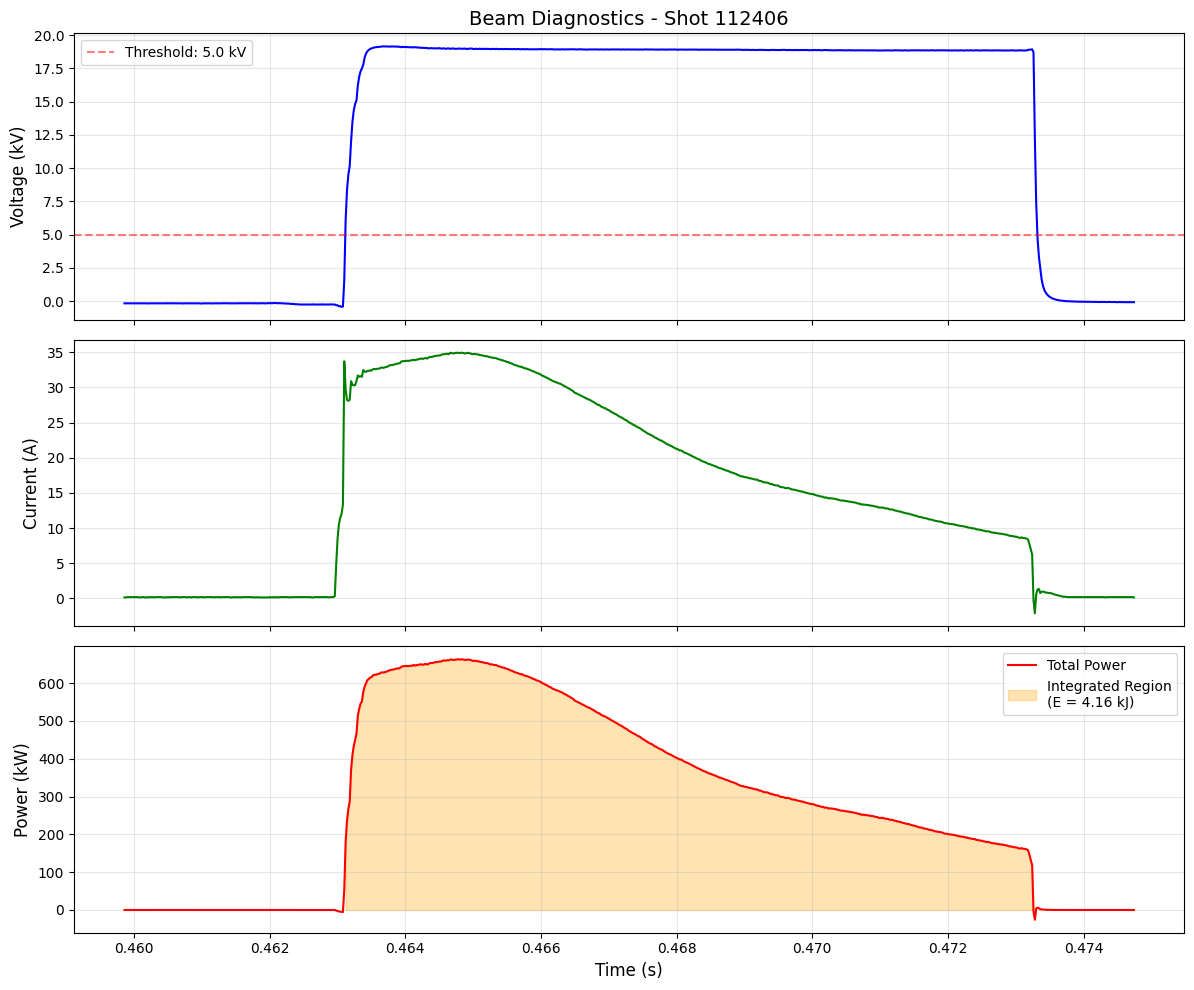


Beam-on duration: 0.0102 s
Average power during beam-on: 408.40 kW
Total energy delivered: 4.16 kJ


In [29]:
#CHECKING BEAM ENERGY FOR A SPECIFIC SHOT ENTER MANUALLY
shot = 112406
v_thresh = 5000.0

#for new shots use ltx_nbi tree directly and for anythign less use ltx_b tree
if shot > 200000:
    treename = 'ltx_nbi'
    prefix = ''
else:
    treename = 'ltx_b'
    prefix = '.oper_diags.ltx_nbi'

tree = get_tree_conn(shot, treename=treename)
(ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
(tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')

# Interpolate current to voltage time base
ib = np.interp(tv, ti, ib)
pb = ib * vb / 1000.0  # Power in kW

# Mask for beam-on period (V > 5 kV)
mask = vb > v_thresh

# Calculate total energy
tv_beam = tv[mask]
pb_beam = pb[mask]
total_energy = np.trapz(pb_beam, tv_beam)

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot voltage
ax1.plot(tv, vb/1000, 'b-', linewidth=1.5)
ax1.axhline(y=v_thresh/1000, color='r', linestyle='--', alpha=0.5, label=f'Threshold: {v_thresh/1000:.1f} kV')
ax1.set_ylabel('Voltage (kV)', fontsize=12)
ax1.set_title(f'Beam Diagnostics - Shot {shot}', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot current
ax2.plot(tv, ib, 'g-', linewidth=1.5)
ax2.set_ylabel('Current (A)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot power
ax3.plot(tv, pb, 'r-', linewidth=1.5, label='Total Power')
ax3.fill_between(tv_beam, 0, pb_beam, alpha=0.3, color='orange', label=f'Integrated Region\n(E = {total_energy:.2f} kJ)')
ax3.set_ylabel('Power (kW)', fontsize=12)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

print(f"\nBeam-on duration: {tv_beam[-1] - tv_beam[0]:.4f} s")
print(f"Average power during beam-on: {np.mean(pb_beam):.2f} kW")
print(f"Total energy delivered: {total_energy:.2f} kJ")


SEGMENT-BY-SEGMENT ANALYSIS

Shot: 112394.txt | Beam Energy: 3.68 kJ
Wire_Label  V_seg_1 (V)  V_seg_2 (V)  ΔV_seg (V)  ΔT_seg (°C)  ΔT_seg/E (°C/kJ)
 w1 (1-14)     0.504630     0.529843    0.025213    11.103109          3.019050
 w2 (14-2)     0.499619     0.539230    0.039611    17.618413          4.790629
 w3 (2-15)     0.529351     0.582875    0.053525    22.469662          6.109733
 w4 (15-3)     0.548445     0.609999    0.061554    24.940947          6.781701
 w5 (3-16)     0.545125     0.604443    0.059318    24.181269          6.575137
 w6 (16-4)     0.497804     0.546444    0.048640    21.713114          5.904020
 w7 (4-17)     0.513949     0.549481    0.035532    15.363503          4.177495
 w8 (17-5)     1.040980     1.090993    0.050014    10.676630          2.903086
 w9 (5-18)     0.538810     0.580006    0.041196    16.990459          4.619882
w10 (18-6)     0.536576     0.589334    0.052758    21.849615          5.941136
w11 (6-19)     0.544633     0.603840    0.059208  

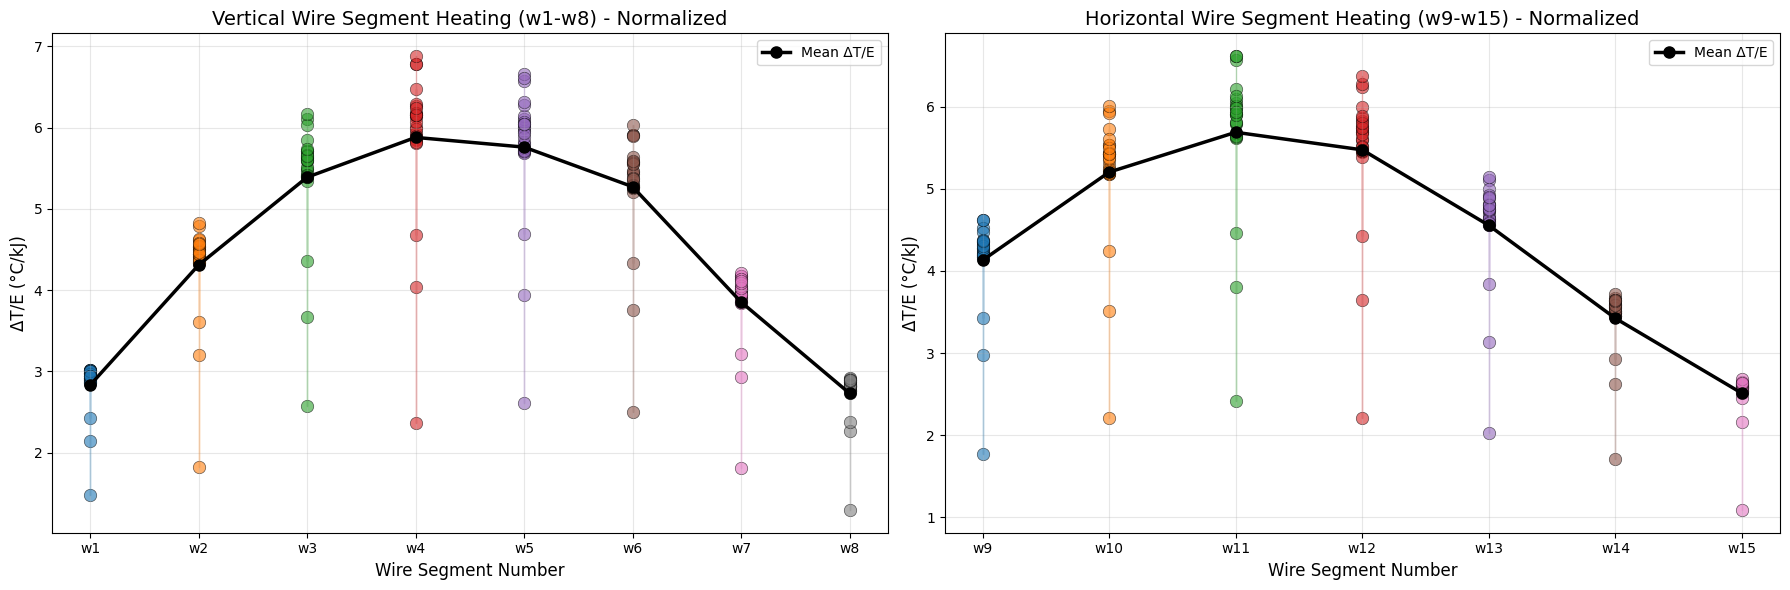



AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)

Shots ranked by Average Segment ΔT (Highest to Lowest):
 Rank       Shot    Avg_ΔT   Std_ΔT    Max_ΔT  Avg_ΔT/E   Beam_E
    1 112406.txt 20.141727 5.530451 26.989411  4.837331 4.163810
    2 112405.txt 19.579438 5.346951 26.066505  4.725559 4.143306
    3 112403.txt 19.458621 5.262417 25.839726  4.716271 4.125849
    4 112398.txt 19.095071 5.609464 26.048677  5.044449 3.785363
    5 112419.txt 18.899708 4.928909 24.770450  4.718571 4.005388
    6 112401.txt 18.755419 5.090317 24.871294  4.622224 4.057662
    7 112435.txt 18.656136 5.082459 24.597295  4.793060 3.892323
    8 112402.txt 18.646826 4.957355 24.652135  4.660312 4.001197
    9 112433.txt 18.596442 4.797211 24.286554  4.717546 3.941974
   10 112404.txt 18.539619 5.042885 24.770704  4.613430 4.018619
   11 112394.txt 18.388813 5.326400 24.940947  5.000108 3.677683
   12 112413.txt 18.224772 4.835367 24.122511  4.534895 4.018786
   13 112427.txt 18.066091 4.690705 

In [30]:
# ===== SEGMENT-BY-SEGMENT ANALYSIS =====
# Each segment is isolated by taking voltage difference between adjacent channels

print("\n" + "="*100)
print("SEGMENT-BY-SEGMENT ANALYSIS")
print("="*100)

# Define segment mappings: (name, high_ch, low_ch, label)
segment_mappings = [
    ('w1', 0, 1, '1-14'),     # w1 = ch0 - ch1
    ('w2', 1, 2, '14-2'),     # w2 = ch1 - ch2
    ('w3', 2, 3, '2-15'),
    ('w4', 3, 4, '15-3'),
    ('w5', 4, 5, '3-16'),
    ('w6', 5, 6, '16-4'),
    ('w7', 6, 7, '4-17'),
    ('w8', 7, 8, '17-5'),     # to center tap
    ('w9', 8, 9, '5-18'),
    ('w10', 9, 10, '18-6'),
    ('w11', 10, 11, '6-19'),
    ('w12', 11, 12, '19-7'),
    ('w13', 12, 13, '7-20'),
    ('w14', 13, 14, '20-8'),
    ('w15', 14, 15, '8-21'),
]

segment_results = []

for shot_file, df in datasets.items():
    shot_num = int(Path(shot_file).stem)
    beam_E = beam_energies[shot_file]
    
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"] and "16" not in c]
    
    # Get voltage averages before and after heating
    v1_start, v1_end = 0, 2000      # first 2 seconds
    v2_start, v2_end = 1800, 3800    # 2 seconds starting at t=1.8s
    
    ch_v1 = {}
    ch_v2 = {}
    
    for idx, col in enumerate(channel_cols):
        y = df[col].values
        ch_v1[idx] = np.mean(y[v1_start:v1_end])
        ch_v2[idx] = np.mean(y[v2_start:v2_end])
    
    # Calculate heating for each segment
    for wire, ch_high, ch_low, phys_label in segment_mappings:
        if ch_high not in ch_v1 or ch_low not in ch_v1:
            continue
        
        # Voltage across this segment before and after
        V1 = ch_v1[ch_high] - ch_v1[ch_low]
        V2 = ch_v2[ch_high] - ch_v2[ch_low]
        dV = V2 - V1
        
        # Convert to resistance and temperature
        dR = dV / WIRE_CURRENT
        R1 = V1 / WIRE_CURRENT
        
        dT = dR / (R1 * TCR) if R1 > 0 else np.nan
        dT_norm = dT / beam_E if (not np.isnan(dT) and beam_E > 0) else np.nan
        
        segment_results.append({
            'Shot': shot_file,
            'Wire_Name': wire,
            'Wire_Label': f'{wire} ({phys_label})',
            'Ch_High': ch_high,
            'Ch_Low': ch_low,
            'V_seg_1 (V)': V1,
            'V_seg_2 (V)': V2,
            'ΔV_seg (V)': dV,
            'R_seg_1 (Ω)': R1,
            'ΔR_seg (Ω)': dR,
            'ΔT_seg (°C)': dT,
            'Beam Energy (kJ)': beam_E,
            'ΔT_seg/E (°C/kJ)': dT_norm
        })

segment_df = pd.DataFrame(segment_results)

# Print results for each shot
for shot_file in segment_df['Shot'].unique():
    shot_data = segment_df[segment_df['Shot'] == shot_file]
    energy = shot_data['Beam Energy (kJ)'].iloc[0]
    
    print(f"\n{'='*100}")
    print(f"Shot: {shot_file} | Beam Energy: {energy:.2f} kJ")
    print(f"{'='*100}")
    print(shot_data[['Wire_Label', 'V_seg_1 (V)', 'V_seg_2 (V)', 'ΔV_seg (V)', 
                     'ΔT_seg (°C)', 'ΔT_seg/E (°C/kJ)']].to_string(index=False))

# Calculate stats for plotting
seg_stats = segment_df.groupby(['Wire_Name', 'Wire_Label']).agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max']
}).reset_index()

seg_stats.columns = ['Wire_Name', 'Wire_Label', 'ΔT_mean', 'ΔT_std', 'ΔT_min', 'ΔT_max',
                     'ΔT/E_mean', 'ΔT/E_std', 'ΔT/E_min', 'ΔT/E_max']

seg_stats['sort_key'] = seg_stats['Wire_Name'].str.extract('(\d+)').astype(int)
seg_stats = seg_stats.sort_values('sort_key').drop('sort_key', axis=1)

# ===== PLOTS: SEGMENT HEATING PROFILES =====
print("\n\nCreating segment heating plots (normalized by beam energy)...")

all_wires = sorted(segment_df['Wire_Name'].unique(), key=lambda x: int(x[1:]))
vert_wires = [w for w in all_wires if w in ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']]
horiz_wires = [w for w in all_wires if w in ['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Vertical wires
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax1.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax1.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for vertical
vert_means, vert_x = [], []
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    vert_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    vert_x.append(int(wire[1:]))
ax1.plot(vert_x, vert_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax1.set_xlabel('Wire Segment Number', fontsize=12)
ax1.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax1.set_title('Vertical Wire Segment Heating (w1-w8) - Normalized', fontsize=14)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8'])
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)

# Horizontal wires
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax2.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for horizontal
horiz_means, horiz_x = [], []
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    horiz_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    horiz_x.append(int(wire[1:]))
ax2.plot(horiz_x, horiz_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax2.set_xlabel('Wire Segment Number', fontsize=12)
ax2.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax2.set_title('Horizontal Wire Segment Heating (w9-w15) - Normalized', fontsize=14)
ax2.set_xticks([9, 10, 11, 12, 13, 14, 15])
ax2.set_xticklabels(['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15'])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

# ===== AVG SEGMENT HEATING PER SHOT =====
print("\n\n" + "="*100)
print("AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)")
print("="*100)

# Average all segments for each shot
shot_avg = segment_df.groupby('Shot').agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max'],
    'Beam Energy (kJ)': 'first'
}).reset_index()

shot_avg.columns = ['Shot', 'Avg_ΔT', 'Std_ΔT', 'Min_ΔT', 'Max_ΔT',
                    'Avg_ΔT/E', 'Std_ΔT/E', 'Min_ΔT/E', 'Max_ΔT/E', 'Beam_E']

# Rank by raw heating
by_temp = shot_avg.sort_values('Avg_ΔT', ascending=False).reset_index(drop=True)
by_temp['Rank'] = by_temp.index + 1

print("\nShots ranked by Average Segment ΔT (Highest to Lowest):")
print(by_temp[['Rank', 'Shot', 'Avg_ΔT', 'Std_ΔT', 'Max_ΔT', 'Avg_ΔT/E', 'Beam_E']].to_string(index=False))

# Rank by normalized heating
by_norm = shot_avg.sort_values('Avg_ΔT/E', ascending=False).reset_index(drop=True)
by_norm['Rank'] = by_norm.index + 1

print("\n\nShots ranked by Average Segment ΔT/E (Highest to Lowest):")
print(by_norm[['Rank', 'Shot', 'Avg_ΔT/E', 'Std_ΔT/E', 'Max_ΔT/E', 'Avg_ΔT', 'Beam_E']].to_string(index=False))

print("\n" + "="*100)
print("Segment-by-segment analysis complete!")
print("="*100)